In [1]:
#Still in alpha :)
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer.reparam import TransformReparam
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

<BarContainer object of 8 artists>

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


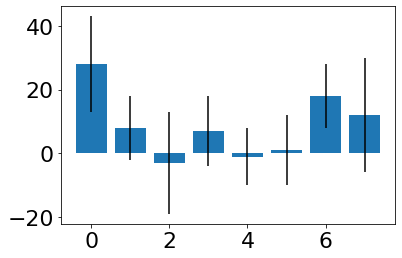

In [2]:
#Eight Schools example
#What are the effects of coaching on SAT performance?

J = 8 #number of schools
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])
assert len(sigma) == len(y)

plt.bar(np.arange(J), y, yerr=sigma)

In [3]:
def eight_schools(J, sigma, y=None):
    """
    y_j ~ Normal(theta_j, sigma_j), j=1,...,8
    theta_j ~ Normal(mu, tau), j=1, ..., 8
    mu ~ Normal(0, 5)
    tau ~ HalfCauchy(5)
    """
    mu = numpyro.sample('mu', dist.Normal(0, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    with numpyro.plate('J', J):
        theta = numpyro.sample('theta', dist.Normal(mu, tau))
        numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

In [4]:
#What does the HalfCauchy(5) distribution look like?

def hc(n, y=None):
    numpyro.sample('mu2', dist.HalfCauchy(n))
    
hc_kernal = NUTS(hc)
mcmc_hc = MCMC(hc_kernal, num_warmup=500, num_samples=1000)
rng_key = random.PRNGKey(1731)
n=5
mcmc_hc.run(rng_key, n, extra_fields=('potential_energy', ))

nuts_kernal = NUTS(eight_schools)
mcmc = MCMC(nuts_kernal, num_warmup=500, num_samples=1000)
rng_key = random.PRNGKey(222)
mcmc.run(rng_key, J, sigma, y=y, extra_fields=('potential_energy', ))

sample: 100%|██████████████████████████| 1500/1500 [00:03<00:00, 480.70it/s, 15 steps of size 6.89e-02. acc. prob=0.95]


In [5]:
hc_samples = mcmc_hc.get_samples()

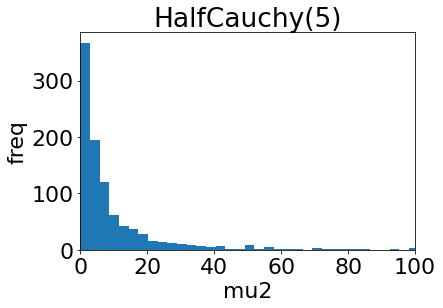

In [6]:
def hist(x, title, xlabel, ylabel, bins=None, xlim=None, ylim=None):
    plt.hist(x, bins=bins)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()

hist(hc_samples['mu2'], 'HalfCauchy(5)', 'mu2', 'freq', bins=500,
    xlim=(0, 100))

In [7]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      3.99      3.19      4.07     -1.71      8.46    164.14      1.00
       tau      4.06      3.08      3.36      0.28      8.19     90.18      1.00
  theta[0]      5.99      5.69      5.61     -3.26     14.17    201.30      1.00
  theta[1]      4.73      4.84      4.38     -2.55     13.57    301.50      1.00
  theta[2]      3.16      5.33      3.54     -5.19     11.49    205.42      1.00
  theta[3]      4.19      4.95      4.17     -3.63     12.12    346.66      1.00
  theta[4]      3.06      4.92      3.26     -4.36     11.11    289.14      1.00
  theta[5]      3.41      4.93      3.51     -5.42     10.19    305.11      1.00
  theta[6]      6.12      5.14      5.63     -2.22     14.32    214.45      1.00
  theta[7]      4.44      5.58      4.45     -3.58     14.71    350.76      1.00

Number of divergences: 9


In [65]:
# Eight Schools non centered example - Non centered Reparametrization

def eight_schools_noncentered(J, sigma, y=None):
    mu = numpyro.sample('mu', dist.Normal(0, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    with numpyro.plate('J', J):
        with numpyro.handlers.reparam(config={'theta': TransformReparam()}):
            theta = numpyro.sample(
                'theta',
                dist.TransformedDistribution(dist.Normal(0., 1.),
                                             dist.transforms.AffineTransform(mu, tau)))
        numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)
        
nuts_kernal = NUTS(eight_schools_noncentered)
mcmc = MCMC(nuts_kernal, num_warmup=500, num_samples=1000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, J, sigma, y=y, extra_fields=('potential_energy', ))
mcmc.print_summary(exclude_deterministic=False)

sample: 100%|██████████████████████████| 1500/1500 [00:03<00:00, 461.06it/s, 15 steps of size 3.71e-02. acc. prob=0.94]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
           mu      5.90      3.71      6.22      0.04     11.70    121.64      1.04
          tau     11.01      2.91     10.43      7.02     14.98    107.16      1.01
     theta[0]     27.96      0.51     27.97     27.25     28.89   1095.89      1.00
     theta[1]      7.99      0.50      8.00      7.17      8.79   1012.18      1.00
     theta[2]     -2.99      0.48     -2.97     -3.75     -2.17   1121.48      1.00
     theta[3]      6.99      0.48      7.01      6.23      7.83    903.09      1.00
     theta[4]     -0.98      0.52     -0.97     -1.91     -0.17   1086.04      1.00
     theta[5]      1.01      0.51      1.00      0.17      1.85   1311.30      1.00
     theta[6]     17.98      0.50     17.96     17.26     18.88    990.18      1.00
     theta[7]     11.99      0.48     11.98     11.21     12.78    970.21      1.00
theta_base[0]      2.11      0.52      2.10      1.21      2.85     97.05  

In [66]:
pe = mcmc.get_extra_fields()['potential_energy']
# Compare with the earlier value
print('Expected log joint density: {:.2f}'.format(np.mean(-pe)))

Expected log joint density: -22.51


In [9]:
def normal(mu, sigma):
    numpyro.sample('obs', dist.Normal(mu, sigma))

mu = 5
sigma = 0.5
nuts_kernal = NUTS(normal)
mcmc = MCMC(nuts_kernal, num_warmup=500, num_samples=1000)
rng_key = random.PRNGKey(222)
mcmc.run(rng_key, mu, sigma, extra_fields=('potential_energy', ))

sample: 100%|███████████████████████████| 1500/1500 [00:02<00:00, 661.53it/s, 3 steps of size 9.72e-01. acc. prob=0.93]


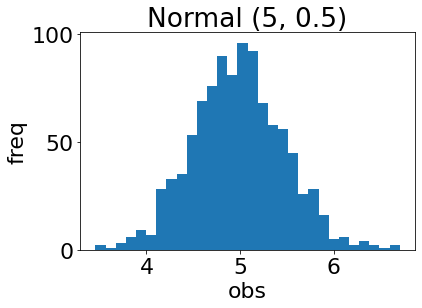

In [10]:
def hist_samples(mcmc, title, bins=None):
    params = mcmc.get_samples()
    samples = 0
    name = ''
    for key in params:
        samples = params[key]
        name = key
        break
    hist(samples, title, name, 'freq', bins=bins)

hist_samples(mcmc, 'Normal (5, 0.5)', bins=30)
    

In [11]:
def poisson(lam):
    numpyro.sample('obs', dist.discrete.Poisson)

lam = 50

nuts_kernal = NUTS(poisson)
mcmc = MCMC(nuts_kernal, num_warmup=500, num_samples=1000)
rng_key = random.PRNGKey(222)
mcmc.run(rng_key, lam, extra_fields=('potential_energy', ))

RuntimeError: MCMC only supports continuous sites or discrete sites with enumerate support, but got Poisson.

In [24]:
p = dist.discrete.Poisson().sample(rng_key, sample_shape=((200, 1)))

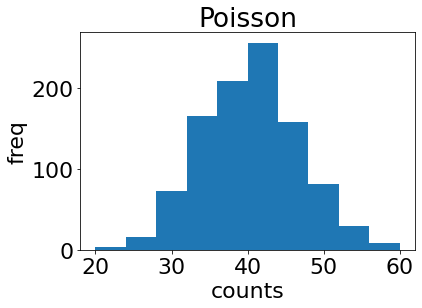

In [52]:
hist(dist.Poisson(40).sample(random.PRNGKey(3), sample_shape=(1000, )),
    'Poisson', 'counts', 'freq', bins=10)

#params, PRNGKey, sample_shape -> DeviceArray shape sample_shape
#Output is a device array of samples


#What algorithm is being used to sample discrete distributions in NumPyro?

#To sample the poisson distribution Numpyro calls JAX's
#random.poisson(key, self.rate, shape=sample_shape + self.batch_shape)

#Uses the Knuth algorithm if lam < 10



#Else transformed rejection sampling

In [67]:
import imp

In [69]:
print(imp.__doc__)

This module provides the components needed to build your own __import__
function.  Undocumented functions are obsolete.

In most cases it is preferred you consider using the importlib module's
functionality over this module.




In [59]:
#What are the discrete distributions availible in numpyro?

"""
 'softmax',
 'softplus',
 'expit',
 'gammaincc',
 'gammaln',
 'logsumexp',
 'xlog1py',
 'xlogy',
 'constraints',
 'Distribution',
 'binomial',
 'categorical',
 'multinomial',
 'BernoulliProbs',
 'BernoulliLogits',
 'Bernoulli',
 'BinomialProbs',
 'BinomialLogits',
 'Binomial',
 'CategoricalProbs',
 'CategoricalLogits',
 'Categorical',
 'OrderedLogistic',
 'PRNGIdentity',
 'MultinomialProbs',
 'MultinomialLogits',
 'Multinomial',
 'Poisson',
 'ZeroInflatedProbs',
 'ZeroInflatedLogits',
 'ZeroInflatedDistribution',
 'ZeroInflatedPoisson',
 'GeometricProbs',
 'GeometricLogits',
 'Geometric'
"""

"\n 'warnings',\n 'np',\n 'jax',\n 'lax',\n 'softmax',\n 'softplus',\n 'jnp',\n 'random',\n 'expit',\n 'gammaincc',\n 'gammaln',\n 'logsumexp',\n 'xlog1py',\n 'xlogy',\n 'constraints',\n 'Distribution',\n 'binomial',\n 'categorical',\n 'multinomial',\n 'BernoulliProbs',\n 'BernoulliLogits',\n 'Bernoulli',\n 'BinomialProbs',\n 'BinomialLogits',\n 'Binomial',\n 'CategoricalProbs',\n 'CategoricalLogits',\n 'Categorical',\n 'OrderedLogistic',\n 'PRNGIdentity',\n 'MultinomialProbs',\n 'MultinomialLogits',\n 'Multinomial',\n 'Poisson',\n 'ZeroInflatedProbs',\n 'ZeroInflatedLogits',\n 'ZeroInflatedDistribution',\n 'ZeroInflatedPoisson',\n 'GeometricProbs',\n 'GeometricLogits',\n 'Geometric'\n"

In [ ]:
"""
The transformers module

 'math',
 'warnings',
 'weakref',
 'np',
 'lax',
 'ops',
 'vmap',
 'softplus',
 'jnp',
 'expit',
 'logit',
 'constraints',
 'Transform',
 'AbsTransform',
 'AffineTransform',
 'ComposeTransform',
 'CholeskyTransform',
 'CorrCholeskyTransform',
 'CorrMatrixCholeskyTransform',
 'ExpTransform',
 'IdentityTransform',
 'IndependentTransform',
 'InvCholeskyTransform',
 'LowerCholeskyAffine',
 'LowerCholeskyTransform',
 'OrderedTransform',
 'PermuteTransform',
 'PowerTransform',
 'SigmoidTransform',
 'SoftplusTransform',
 'SoftplusLowerCholeskyTransform',
 'StickBreakingTransform',
 'UnpackTransform',
 'ConstraintRegistry'
"""

In [58]:
list(i for i in dist.discrete.__dict__.keys() if '_' not in i)

['warnings',
 'np',
 'jax',
 'lax',
 'softmax',
 'softplus',
 'jnp',
 'random',
 'expit',
 'gammaincc',
 'gammaln',
 'logsumexp',
 'xlog1py',
 'xlogy',
 'constraints',
 'Distribution',
 'binomial',
 'categorical',
 'multinomial',
 'BernoulliProbs',
 'BernoulliLogits',
 'Bernoulli',
 'BinomialProbs',
 'BinomialLogits',
 'Binomial',
 'CategoricalProbs',
 'CategoricalLogits',
 'Categorical',
 'OrderedLogistic',
 'PRNGIdentity',
 'MultinomialProbs',
 'MultinomialLogits',
 'Multinomial',
 'Poisson',
 'ZeroInflatedProbs',
 'ZeroInflatedLogits',
 'ZeroInflatedDistribution',
 'ZeroInflatedPoisson',
 'GeometricProbs',
 'GeometricLogits',
 'Geometric']